/Users/josegutierrez/Library/Python/3.9/lib/python/site-packages/pandapower/create.py:2369: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  net.trafo.tap_phase_shifter.fillna(False, inplace=True)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



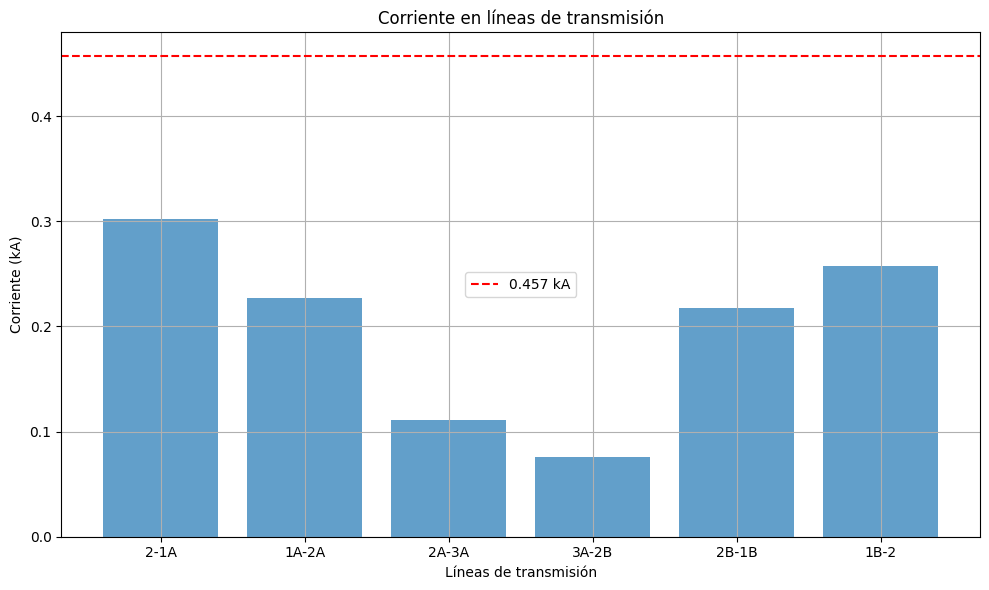

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandapower as pp
import math

# Para la creación de este modelo se asume un sistema trifásico, con voltaje linea-linea de 220[kV],
# analizamos el circuito equivalente para 1 fase

# Definimos los parámetros
f = 50  # frecuencia del sistema en [Hz]

Vg_LL = 110  # voltaje de gen [kV]
Vg_LL2 = 220 # Voltaje de barras
Imax = 0.457  # corriente máxima en las líneas [kA]

# Respecto a la carga
P = 150  # potencia activa en [MW]
Q = 100  # potencia reactiva en [Mvar]

# Crear red eléctrica
net = pp.create_empty_network()

# Añadir barras
bus1 = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 1", slack=True)  # Barra 1 es designada como slack
bus2 = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 2")  # Barra 2 se conecta la carga
bus1A = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 1A")  # Barra 1A se conecta la carga
bus2A = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 2A")  # Barra 2A se conecta la carga
bus3A = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 3A")  # Barra 3A se conecta la carga
bus2B = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 2B")  # Barra 2B se conecta la carga
bus1B = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 1B")  # Barra 1B se conecta la carga

# Añadir líneas
pp.create_line(net, from_bus=bus2, to_bus=bus1A, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus1A, to_bus=bus2A, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus2A, to_bus=bus3A, length_km=20, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus3A, to_bus=bus2B, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus2B, to_bus=bus1B, length_km=30, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus1B, to_bus=bus2, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)

# Añadir carga
pp.create_load(net, bus=bus1A, p_mw=0.2*P, q_mvar=0.2*Q)
pp.create_load(net, bus=bus2A, p_mw=0.35*P, q_mvar=0.35*Q)
pp.create_load(net, bus=bus3A, p_mw=0.15*P, q_mvar=0.15*Q)
pp.create_load(net, bus=bus2B, p_mw=0.6*P, q_mvar=0.6*Q)
pp.create_load(net, bus=bus1B, p_mw=0.1*P, q_mvar=0.1*Q)

# Se añade fuente de generación conectada en la barra 1, (1[pu], el voltaje nominal [kV] se define en la barra a la que está conectada)
pp.create_ext_grid(net, bus=bus1, vm_pu=1, va_degree=0.0)

# Se añade transformador de 100 MVA 220/110 kV entre la barra 1 y la barra 2
pp.create_transformer(net, hv_bus=bus2, lv_bus=bus1, name="trafo1", std_type="100 MVA 220/110 kV")
net.trafo.tap_phase_shifter = net.trafo.tap_phase_shifter.fillna(value=False)

# Simular el flujo de carga
pp.runpp(net)

# Obtener las corrientes de las líneas específicas
line_currents = {
    '2-1A': net.res_line.at[0, 'i_ka'],    # Línea 2-1A
    '1A-2A': net.res_line.at[1, 'i_ka'],   # Línea 1A-2A
    '2A-3A': net.res_line.at[2, 'i_ka'],   # Línea 2A-3A
    '3A-2B': net.res_line.at[3, 'i_ka'],   # Línea 3A-2B
    '2B-1B': net.res_line.at[4, 'i_ka'],   # Línea 2B-1B
    '1B-2': net.res_line.at[5, 'i_ka']     # Línea 1B-2
}

import matplotlib.pyplot as plt

# Crear un gráfico de barras para las corrientes de las líneas específicas
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(line_currents)), line_currents.values(), align='center', alpha=0.7)

# Etiquetar las barras con los nombres de las líneas
plt.xticks(range(len(line_currents)), line_currents.keys())

# Agregar etiquetas y título al gráfico
plt.xlabel('Líneas de transmisión')
plt.ylabel('Corriente (kA)')
plt.title('Corriente en líneas de transmisión')

# Agregar una línea segmentada correspondiente a 0.457 kA
plt.axhline(y=0.457, color='r', linestyle='--', label='0.457 kA')

# Mostrar el gráfico
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



/Users/josegutierrez/Library/Python/3.9/lib/python/site-packages/pandapower/create.py:2369: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  net.trafo.tap_phase_shifter.fillna(False, inplace=True)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



      vm_pu  va_degree        p_mw     q_mvar
0  1.000000   0.000000 -212.310191   5.807279
1  1.033380 -14.276471    0.000000   0.000000
2  1.031457 -14.492303   30.000000  20.000000
3  1.029237 -14.730336   52.500000  35.000000
4  1.028365 -14.864945   22.500000  15.000000
5  1.027435 -14.873522   90.000000  60.000000
6  1.032375 -14.469768   15.000000  10.000000


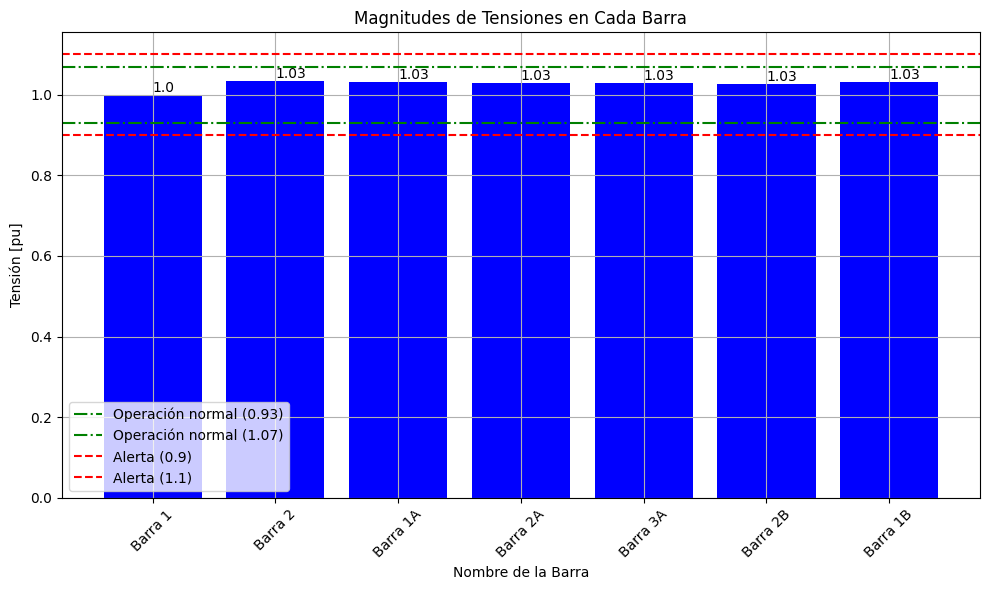

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandapower as pp
import math

# Para la creación de este modelo se asume un sistema trifásico, con voltaje linea-linea de 220[kV],
# analizamos el circuito equivalente para 1 fase

# Definimos los parámetros
f = 50  # frecuencia del sistema en [Hz]

Vg_LL = 110  # voltaje de la línea en [kV]
Vg_LL2 = 220 # Voltaje de barras
Imax = 0.457  # corriente máxima en las líneas [kA]

# Respecto a la carga
P = 150  # potencia activa en [MW]
Q = 100  # potencia reactiva en [Mvar]

# Crear red eléctrica
net = pp.create_empty_network()

# Añadir barras
bus1 = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 1", slack=True)  # Barra 1 es designada como slack
bus2 = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 2")  # Barra 2 se conecta la carga
bus1A = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 1A")  # Barra 1A se conecta la carga
bus2A = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 2A")  # Barra 2A se conecta la carga
bus3A = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 3A")  # Barra 3A se conecta la carga
bus2B = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 2B")  # Barra 2B se conecta la carga
bus1B = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 1B")  # Barra 1B se conecta la carga

# Añadir líneas
pp.create_line(net, from_bus=bus2, to_bus=bus1A, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus1A, to_bus=bus2A, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus2A, to_bus=bus3A, length_km=20, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus3A, to_bus=bus2B, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus2B, to_bus=bus1B, length_km=30, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus1B, to_bus=bus2, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)

# Añadir carga
pp.create_load(net, bus=bus1A, p_mw=0.2*P, q_mvar=0.2*Q)
pp.create_load(net, bus=bus2A, p_mw=0.35*P, q_mvar=0.35*Q)
pp.create_load(net, bus=bus3A, p_mw=0.15*P, q_mvar=0.15*Q)
pp.create_load(net, bus=bus2B, p_mw=0.6*P, q_mvar=0.6*Q)
pp.create_load(net, bus=bus1B, p_mw=0.1*P, q_mvar=0.1*Q)

# Se añade fuente de generación conectada en la barra 1, (1[pu], el voltaje nominal [kV] se define en la barra a la que está conectada)
pp.create_ext_grid(net, bus=bus1, vm_pu=1, va_degree=0.0)

# Se añade transformador de 100 MVA 220/110 kV entre la barra 1 y la barra 2
pp.create_transformer(net, hv_bus=bus2, lv_bus=bus1, name="trafo1", std_type="100 MVA 220/110 kV")
net.trafo.tap_phase_shifter = net.trafo.tap_phase_shifter.fillna(value=False)

# Simular el flujo de carga
pp.runpp(net)

# Imprimir resultados de las barras
print(net.res_bus)

# Obtener resultados de las tensiones en las barras
voltajes = net.res_bus.vm_pu.values
nombres_barras = net.bus.name.values

# Graficar barras de tensiones
plt.figure(figsize=(10, 6))
bars = plt.bar(nombres_barras, voltajes, color='blue')

# Añadir magnitudes numéricas sobre las barras
for bar, valor in zip(bars, voltajes):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(valor, 2), va='bottom')  # Agregar texto encima de la barra

# Agregar línea segmentada para el rango de operación normal (0.93 - 1.07)
plt.axhline(y=0.93, color='green', linestyle='-.', label='Operación normal (0.93)')
plt.axhline(y=1.07, color='green', linestyle='-.', label='Operación normal (1.07)')

# Agregar línea segmentada para el rango de alerta (0.9 - 1.1)
plt.axhline(y=0.9, color='red', linestyle='--', label='Alerta (0.9)')
plt.axhline(y=1.1, color='red', linestyle='--', label='Alerta (1.1)')

plt.title('Magnitudes de Tensiones en Cada Barra')
plt.xlabel('Nombre de la Barra')
plt.ylabel('Tensión [pu]')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
# Obtener las potencias reactivas demandadas desde la barra 2 en adelante
for i in range(1, len(net.bus)):
    bus_name = net.bus.at[i, 'name']
    reactive_power = net.res_bus.q_mvar.at[i]
    print(f"Potencia reactiva demandada en {bus_name}: {reactive_power:.2f} Mvar")

Potencia reactiva demandada en Barra 2: 0.00 Mvar
Potencia reactiva demandada en Barra 1A: 20.00 Mvar
Potencia reactiva demandada en Barra 2A: 35.00 Mvar
Potencia reactiva demandada en Barra 3A: 15.00 Mvar
Potencia reactiva demandada en Barra 2B: 60.00 Mvar
Potencia reactiva demandada en Barra 1B: 10.00 Mvar


/Users/josegutierrez/Library/Python/3.9/lib/python/site-packages/pandapower/create.py:2369: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  net.trafo.tap_phase_shifter.fillna(False, inplace=True)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



      vm_pu  va_degree       p_mw     q_mvar
0  1.000000   0.000000 -212.26966  17.307882
1  1.062521 -14.103497    0.00000   0.000000
2  1.060813 -14.313093   30.00000  20.000000
3  1.058830 -14.544055   52.50000  35.000000
4  1.058090 -14.674927   22.50000  15.000000
5  1.057174 -14.682566   90.00000  60.000000
6  1.061705 -14.291784   15.00000  10.000000


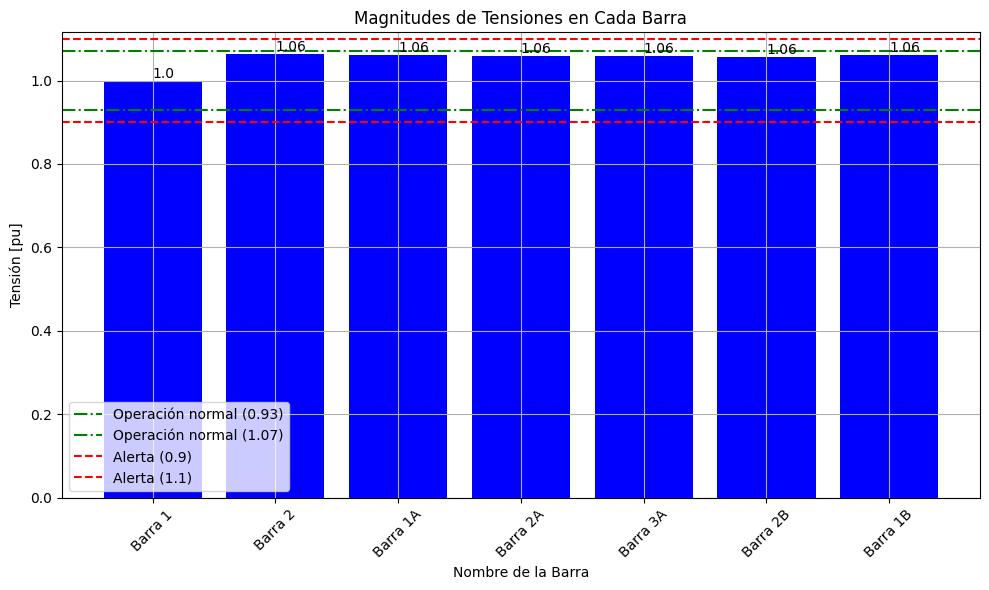

In [17]:
#COMPENSASIÓN POR TAP DEL TRAFO 
import numpy as np
import matplotlib.pyplot as plt
import pandapower as pp

# Definición de parámetros
Vg_LL = 110  # Voltaje de la línea en kV
Vg_LL2 = 220 # Voltaje de barras
P = 150  # Potencia activa en MW
Q = 100  # Potencia reactiva en Mvar

# Creación de la red eléctrica
net = pp.create_empty_network()

# Añadir barras
bus1 = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 1", slack=True)  # Barra 1 es slack
bus2 = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 2")  # Barra 2 se conecta a la carga
bus1A = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 1A")  # Barra 1A se conecta a la carga
bus2A = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 2A")  # Barra 2A se conecta a la carga
bus3A = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 3A")  # Barra 3A se conecta a la carga
bus2B = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 2B")  # Barra 2B se conecta a la carga
bus1B = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 1B")  # Barra 1B se conecta a la carga

# Añadir transformador entre barra 1 y barra 2
trafo1 = pp.create_transformer(net, hv_bus=bus2, lv_bus=bus1, name="trafo1", std_type="100 MVA 220/110 kV")

# Añadir líneas
pp.create_line(net, from_bus=bus2, to_bus=bus1A, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus1A, to_bus=bus2A, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus2A, to_bus=bus3A, length_km=20, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus3A, to_bus=bus2B, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus2B, to_bus=bus1B, length_km=30, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus1B, to_bus=bus2, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)

# Añadir carga a las barras
pp.create_load(net, bus=bus1A, p_mw=0.2 * P, q_mvar=0.2 * Q)
pp.create_load(net, bus=bus2A, p_mw=0.35 * P, q_mvar=0.35 * Q)
pp.create_load(net, bus=bus3A, p_mw=0.15 * P, q_mvar=0.15 * Q)
pp.create_load(net, bus=bus2B, p_mw=0.6 * P, q_mvar=0.6 * Q)
pp.create_load(net, bus=bus1B, p_mw=0.1 * P, q_mvar=0.1 * Q)

# Añadir generación a la barra 1
pp.create_ext_grid(net, bus=bus1, vm_pu=1, va_degree=0.0)

# Definir función para verificar si todas las barras están dentro del rango deseado
def todas_barras_dentro_rango(voltajes):
    for v in voltajes:
        if v < 0.93 or v > 1.07:
            return False
    return True

# Inicializar el tap del transformador para que las barras del sistema estén dentro del rango de operación normal (0.93-1.07 pu)
tap_inicial = 1.0
tap_actual = tap_inicial
net.trafo.tap_pos.at[trafo1] = tap_actual

# Simular el flujo de carga inicial
pp.runpp(net)

# Obtener resultados de las tensiones en las barras
voltajes = net.res_bus.vm_pu.values
nombres_barras = net.bus.name.values

# Iterar para ajustar el tap hasta que todas las barras estén dentro del rango
while not todas_barras_dentro_rango(voltajes):
    if any(v < 0.93 for v in voltajes):
        tap_actual += 0.005
    elif any(v > 1.07 for v in voltajes):
        tap_actual -= 0.005

    net.trafo.tap_pos.at[trafo1] = tap_actual
    pp.runpp(net)
    voltajes = net.res_bus.vm_pu.values

# Imprimir resultados de las barras
print(net.res_bus)

# Graficar barras de tensiones
plt.figure(figsize=(10, 6))
bars = plt.bar(nombres_barras, voltajes, color='blue')

# Añadir texto encima de las barras
for bar, valor in zip(bars, voltajes):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(valor, 2), va='bottom')

# Líneas segmentadas para el rango de operación normal (0.93 - 1.07) y alerta (0.9 - 1.1)
plt.axhline(y=0.93, color='green', linestyle='-.', label='Operación normal (0.93)')
plt.axhline(y=1.07, color='green', linestyle='-.', label='Operación normal (1.07)')
plt.axhline(y=0.9, color='red', linestyle='--', label='Alerta (0.9)')
plt.axhline(y=1.1, color='red', linestyle='--', label='Alerta (1.1)')

plt.title('Magnitudes de Tensiones en Cada Barra')
plt.xlabel('Nombre de la Barra')
plt.ylabel('Tensión [pu]')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


/Users/josegutierrez/Library/Python/3.9/lib/python/site-packages/pandapower/create.py:2369: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  net.trafo.tap_phase_shifter.fillna(False, inplace=True)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



      vm_pu  va_degree        p_mw     q_mvar
0  1.000000   0.000000 -212.505193 -39.235462
1  0.995566 -15.001993    0.000000   0.000000
2  0.993539 -15.203701   30.000000  20.000000
3  0.991273 -15.417030   52.500000  35.000000
4  0.990580 -15.510375   22.500000  15.000000
5  0.984384 -15.585897   90.000000  60.000000
6  0.993198 -15.192318   15.000000  10.000000


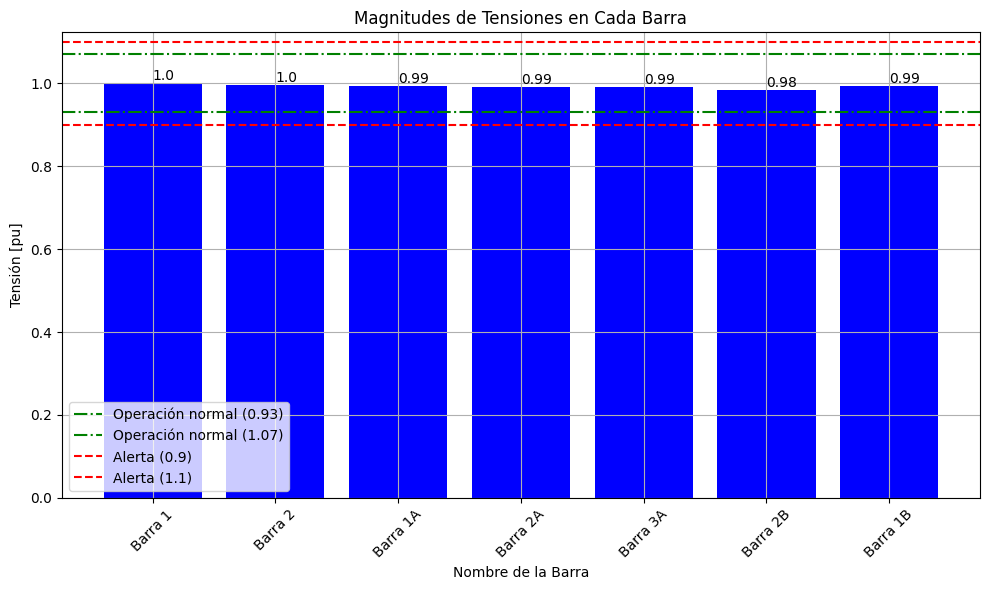

In [18]:
#Ahora desconectando el tramo de línea L3A-2B
import numpy as np
import matplotlib.pyplot as plt
import pandapower as pp

# Definición de parámetros
Vg_LL = 110  # Voltaje de la línea en kV
Vg_LL2 = 220 # Voltaje de barras
P = 150  # Potencia activa en MW
Q = 100  # Potencia reactiva en Mvar

# Creación de la red eléctrica
net = pp.create_empty_network()

# Añadir barras
bus1 = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 1", slack=True)  # Barra 1 es slack
bus2 = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 2")  # Barra 2 se conecta a la carga
bus1A = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 1A")  # Barra 1A se conecta a la carga
bus2A = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 2A")  # Barra 2A se conecta a la carga
bus3A = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 3A")  # Barra 3A se conecta a la carga
bus2B = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 2B")  # Barra 2B se conecta a la carga
bus1B = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 1B")  # Barra 1B se conecta a la carga

# Añadir transformador entre barra 1 y barra 2
trafo1 = pp.create_transformer(net, hv_bus=bus2, lv_bus=bus1, name="trafo1", std_type="100 MVA 220/110 kV")

# Añadir líneas
pp.create_line(net, from_bus=bus2, to_bus=bus1A, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus1A, to_bus=bus2A, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus2A, to_bus=bus3A, length_km=20, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus3A, to_bus=bus2B, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=False)
pp.create_line(net, from_bus=bus2B, to_bus=bus1B, length_km=30, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus1B, to_bus=bus2, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)

# Añadir carga a las barras
pp.create_load(net, bus=bus1A, p_mw=0.2 * P, q_mvar=0.2 * Q)
pp.create_load(net, bus=bus2A, p_mw=0.35 * P, q_mvar=0.35 * Q)
pp.create_load(net, bus=bus3A, p_mw=0.15 * P, q_mvar=0.15 * Q)
pp.create_load(net, bus=bus2B, p_mw=0.6 * P, q_mvar=0.6 * Q)
pp.create_load(net, bus=bus1B, p_mw=0.1 * P, q_mvar=0.1 * Q)

# Añadir generación a la barra 1
pp.create_ext_grid(net, bus=bus1, vm_pu=1, va_degree=0.0)

# Definir función para verificar si todas las barras están dentro del rango deseado
def todas_barras_dentro_rango(voltajes):
    for v in voltajes:
        if v < 0.93 or v > 1.07:
            return False
    return True

# Inicializar el tap del transformador para que las barras del sistema estén dentro del rango de operación normal (0.93-1.07 pu)
tap_inicial = 1.0
tap_actual = tap_inicial
net.trafo.tap_pos.at[trafo1] = tap_actual

# Simular el flujo de carga inicial
pp.runpp(net)

# Obtener resultados de las tensiones en las barras
voltajes = net.res_bus.vm_pu.values
nombres_barras = net.bus.name.values

# Iterar para ajustar el tap hasta que todas las barras estén dentro del rango
while not todas_barras_dentro_rango(voltajes):
    if any(v < 0.93 for v in voltajes):
        tap_actual += 0.005
    elif any(v > 1.07 for v in voltajes):
        tap_actual -= 0.005

    net.trafo.tap_pos.at[trafo1] = tap_actual
    pp.runpp(net)
    voltajes = net.res_bus.vm_pu.values

# Imprimir resultados de las barras
print(net.res_bus)

# Graficar barras de tensiones
plt.figure(figsize=(10, 6))
bars = plt.bar(nombres_barras, voltajes, color='blue')

# Añadir texto encima de las barras
for bar, valor in zip(bars, voltajes):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(valor, 2), va='bottom')

# Líneas segmentadas para el rango de operación normal (0.93 - 1.07) y alerta (0.9 - 1.1)
plt.axhline(y=0.93, color='green', linestyle='-.', label='Operación normal (0.93)')
plt.axhline(y=1.07, color='green', linestyle='-.', label='Operación normal (1.07)')
plt.axhline(y=0.9, color='red', linestyle='--', label='Alerta (0.9)')
plt.axhline(y=1.1, color='red', linestyle='--', label='Alerta (1.1)')

plt.title('Magnitudes de Tensiones en Cada Barra')
plt.xlabel('Nombre de la Barra')
plt.ylabel('Tensión [pu]')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


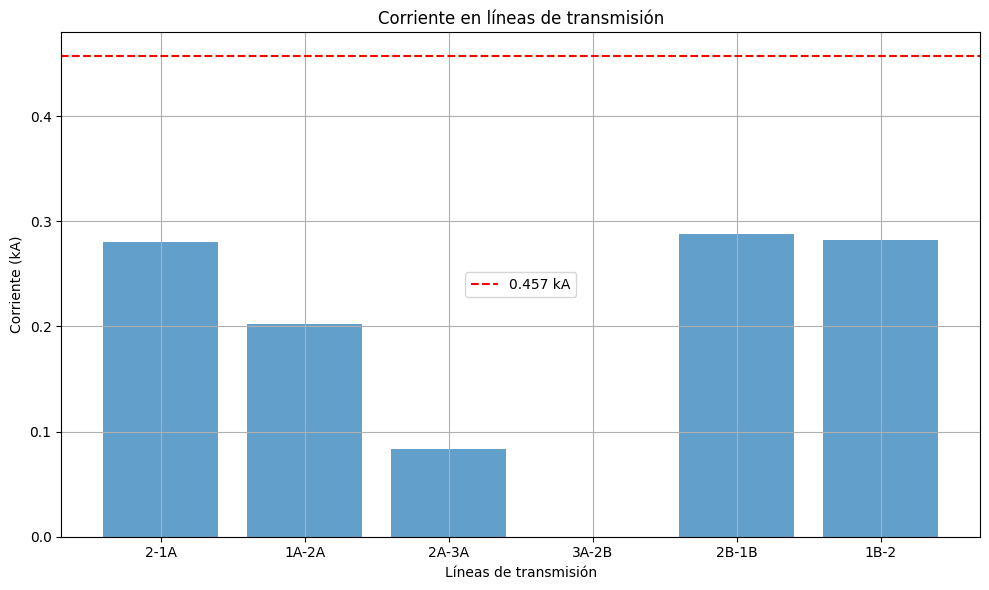

In [19]:

# Obtener las corrientes de las líneas específicas
line_currents = {
    '2-1A': net.res_line.at[0, 'i_ka'],    # Línea 2-1A
    '1A-2A': net.res_line.at[1, 'i_ka'],   # Línea 1A-2A
    '2A-3A': net.res_line.at[2, 'i_ka'],   # Línea 2A-3A
    '3A-2B': net.res_line.at[3, 'i_ka'],   # Línea 3A-2B
    '2B-1B': net.res_line.at[4, 'i_ka'],   # Línea 2B-1B
    '1B-2': net.res_line.at[5, 'i_ka']     # Línea 1B-2
}

import matplotlib.pyplot as plt

# Crear un gráfico de barras para las corrientes de las líneas específicas
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(line_currents)), line_currents.values(), align='center', alpha=0.7)

# Etiquetar las barras con los nombres de las líneas
plt.xticks(range(len(line_currents)), line_currents.keys())

# Agregar etiquetas y título al gráfico
plt.xlabel('Líneas de transmisión')
plt.ylabel('Corriente (kA)')
plt.title('Corriente en líneas de transmisión')

# Agregar una línea segmentada correspondiente a 0.457 kA
plt.axhline(y=0.457, color='r', linestyle='--', label='0.457 kA')

# Mostrar el gráfico
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



/Users/josegutierrez/Library/Python/3.9/lib/python/site-packages/pandapower/create.py:2369: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  net.trafo.tap_phase_shifter.fillna(False, inplace=True)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



      vm_pu  va_degree        p_mw     q_mvar
0  1.000000   0.000000 -212.436472 -39.325094
1  0.995440 -14.998809    0.000000   0.000000
2  0.992716 -15.205121   30.000000  24.000000
3  0.989603 -15.432872   52.500000  42.000000
4  0.988249 -15.562231   22.500000  18.000000
5  0.987226 -15.569501   90.000000  72.000000
6  0.993767 -15.184382   15.000000  12.000000


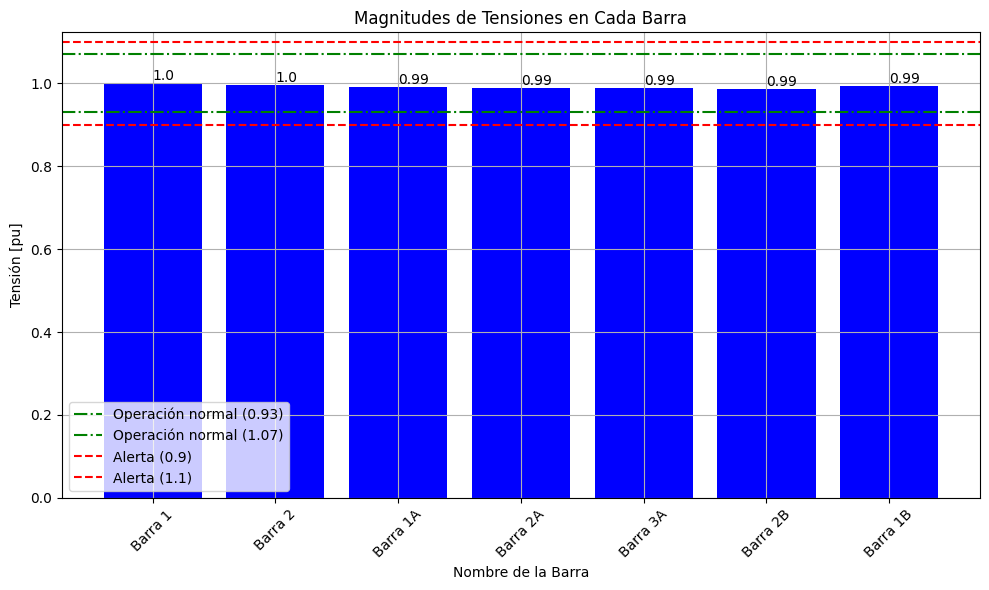

In [20]:
#AUMENTO DE LA POTENCIA EN UUN 20% DESDE EL GENERADOR 
import numpy as np
import matplotlib.pyplot as plt
import pandapower as pp

# Definición de parámetros
Vg_LL = 110  # Voltaje de la línea en kV
Vg_LL2 = 220 # Voltaje de barras
P = 150  # Potencia activa en MW
Q = 100  # Potencia reactiva en Mvar

# Aumento del 20% en la potencia reactiva
Q_incrementado = Q * 1.20

# Creación de la red eléctrica
net = pp.create_empty_network()

# Añadir barras
bus1 = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 1", slack=True)  # Barra 1 es slack
bus2 = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 2")  # Barra 2 se conecta a la carga
bus1A = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 1A")  # Barra 1A se conecta a la carga
bus2A = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 2A")  # Barra 2A se conecta a la carga
bus3A = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 3A")  # Barra 3A se conecta a la carga
bus2B = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 2B")  # Barra 2B se conecta a la carga
bus1B = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 1B")  # Barra 1B se conecta a la carga

# Añadir transformador entre barra 1 y barra 2
trafo1 = pp.create_transformer(net, hv_bus=bus2, lv_bus=bus1, name="trafo1", std_type="100 MVA 220/110 kV")

# Añadir líneas
pp.create_line(net, from_bus=bus2, to_bus=bus1A, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus1A, to_bus=bus2A, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus2A, to_bus=bus3A, length_km=20, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus3A, to_bus=bus2B, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus2B, to_bus=bus1B, length_km=30, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus1B, to_bus=bus2, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)

# Añadir carga a las barras
pp.create_load(net, bus=bus1A, p_mw=0.2 * P, q_mvar=0.2 * Q_incrementado)
pp.create_load(net, bus=bus2A, p_mw=0.35 * P, q_mvar=0.35 * Q_incrementado)
pp.create_load(net, bus=bus3A, p_mw=0.15 * P, q_mvar=0.15 * Q_incrementado)
pp.create_load(net, bus=bus2B, p_mw=0.6 * P, q_mvar=0.6 * Q_incrementado)
pp.create_load(net, bus=bus1B, p_mw=0.1 * P, q_mvar=0.1 * Q_incrementado)

# Añadir generación a la barra 1 con 20% más de reactivos
pp.create_ext_grid(net, bus=bus1, vm_pu=1, va_degree=0.0, s_sc_max_mva=np.sqrt((P**2) + (Q_incrementado**2)), rx_max=Q_incrementado/P)

# Definir función para verificar si todas las barras están dentro del rango deseado
def todas_barras_dentro_rango(voltajes):
    for v in voltajes:
        if v < 0.93 or v > 1.07:
            return False
    return True

# Inicializar el tap del transformador para que las barras del sistema estén dentro del rango de operación normal (0.93-1.07 pu)
tap_inicial = 1.0
tap_actual = tap_inicial
net.trafo.tap_pos.at[trafo1] = tap_actual

# Simular el flujo de carga inicial
pp.runpp(net)

# Obtener resultados de las tensiones en las barras
voltajes = net.res_bus.vm_pu.values
nombres_barras = net.bus.name.values

# Iterar para ajustar el tap hasta que todas las barras estén dentro del rango
while not todas_barras_dentro_rango(voltajes):
    if any(v < 0.93 for v in voltajes):
        tap_actual += 0.005
    elif any(v > 1.07 for v in voltajes):
        tap_actual -= 0.005

    net.trafo.tap_pos.at[trafo1] = tap_actual
    pp.runpp(net)
    voltajes = net.res_bus.vm_pu.values

# Imprimir resultados de las barras
print(net.res_bus)

# Graficar barras de tensiones
plt.figure(figsize=(10, 6))
bars = plt.bar(nombres_barras, voltajes, color='blue')

# Añadir texto encima de las barras
for bar, valor in zip(bars, voltajes):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(valor, 2), va='bottom')

# Líneas segmentadas para el rango de operación normal (0.93 - 1.07) y alerta (0.9 - 1.1)
plt.axhline(y=0.93, color='green', linestyle='-.', label='Operación normal (0.93)')
plt.axhline(y=1.07, color='green', linestyle='-.', label='Operación normal (1.07)')
plt.axhline(y=0.9, color='red', linestyle='--', label='Alerta (0.9)')
plt.axhline(y=1.1, color='red', linestyle='--', label='Alerta (1.1)')

plt.title('Magnitudes de Tensiones en Cada Barra')
plt.xlabel('Nombre de la Barra')
plt.ylabel('Tensión [pu]')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


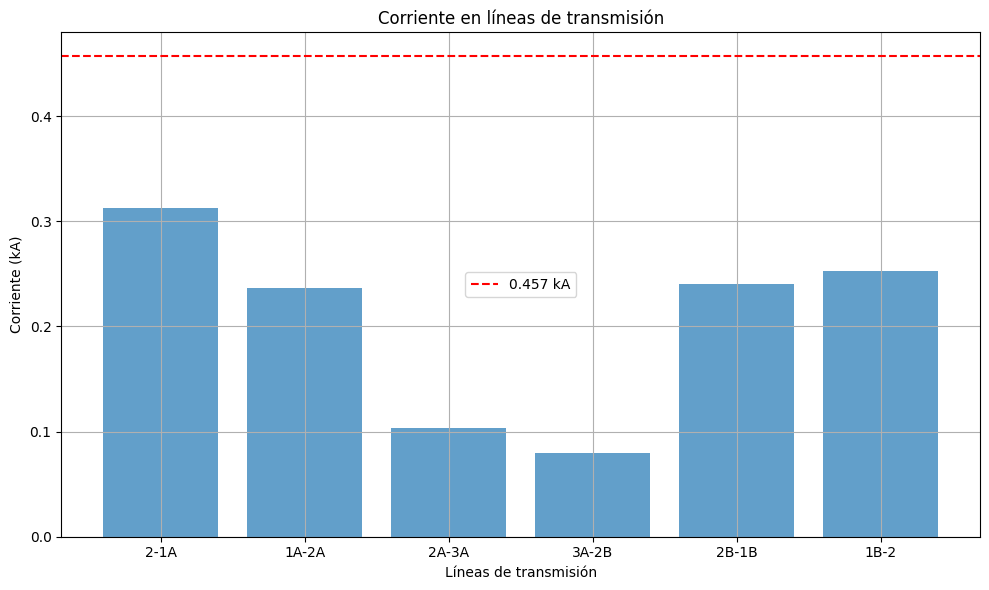

In [21]:
# Obtener las corrientes de las líneas específicas
line_currents = {
    '2-1A': net.res_line.at[0, 'i_ka'],    # Línea 2-1A
    '1A-2A': net.res_line.at[1, 'i_ka'],   # Línea 1A-2A
    '2A-3A': net.res_line.at[2, 'i_ka'],   # Línea 2A-3A
    '3A-2B': net.res_line.at[3, 'i_ka'],   # Línea 3A-2B
    '2B-1B': net.res_line.at[4, 'i_ka'],   # Línea 2B-1B
    '1B-2': net.res_line.at[5, 'i_ka']     # Línea 1B-2
}

import matplotlib.pyplot as plt

# Crear un gráfico de barras para las corrientes de las líneas específicas
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(line_currents)), line_currents.values(), align='center', alpha=0.7)

# Etiquetar las barras con los nombres de las líneas
plt.xticks(range(len(line_currents)), line_currents.keys())

# Agregar etiquetas y título al gráfico
plt.xlabel('Líneas de transmisión')
plt.ylabel('Corriente (kA)')
plt.title('Corriente en líneas de transmisión')

# Agregar una línea segmentada correspondiente a 0.457 kA
plt.axhline(y=0.457, color='r', linestyle='--', label='0.457 kA')

# Mostrar el gráfico
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



/Users/josegutierrez/Library/Python/3.9/lib/python/site-packages/pandapower/create.py:2369: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  net.trafo.tap_phase_shifter.fillna(False, inplace=True)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



      vm_pu  va_degree        p_mw     q_mvar
0  1.000000   0.000000 -212.081376 -40.259909
1  0.994231 -14.990204    0.000000   0.000000
2  0.969254 -17.110594   29.798425  17.787495
3  0.970417 -17.031050   44.896898  30.217475
4  0.973801 -16.747268   25.417149  16.236188
5  0.976403 -16.433389   90.605581  67.292764
6  0.990121 -15.393148   16.204147  10.360283


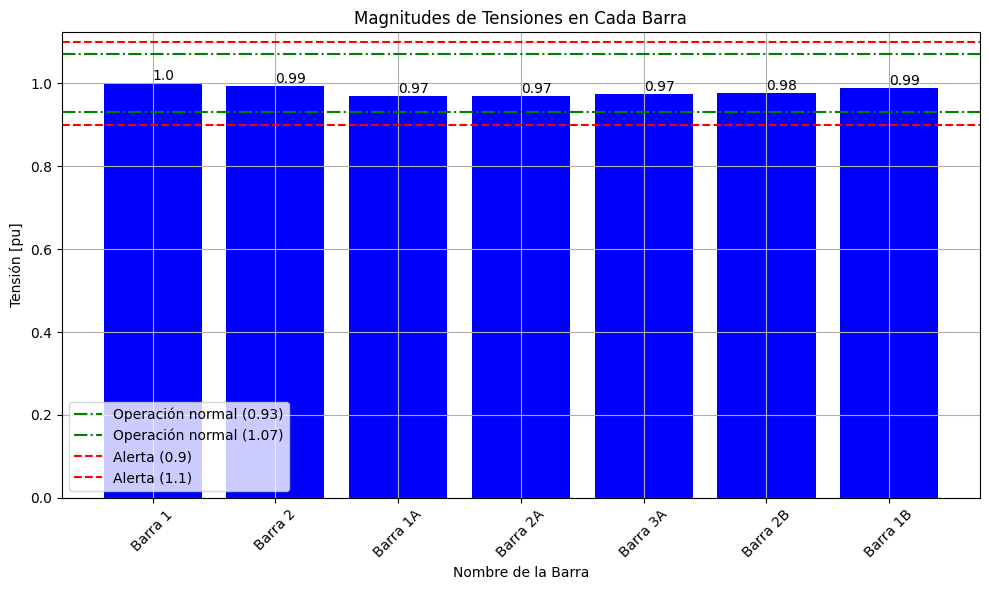

In [22]:
#Instancia 1 Desconexión de la línea 2-1A
import numpy as np
import matplotlib.pyplot as plt
import pandapower as pp

# Definición de parámetros
Vg_LL = 110  # Voltaje de la línea en kV
Vg_LL2 = 220 # Voltaje de barras
P = 150  # Potencia activa en MW
Q = 100  # Potencia reactiva en Mvar

# Creación de la red eléctrica
net = pp.create_empty_network()

# Añadir barras
bus1 = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 1", slack=True)  # Barra 1 es slack
bus2 = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 2")  # Barra 2 se conecta a la carga
bus1A = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 1A")  # Barra 1A se conecta a la carga
bus2A = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 2A")  # Barra 2A se conecta a la carga
bus3A = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 3A")  # Barra 3A se conecta a la carga
bus2B = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 2B")  # Barra 2B se conecta a la carga
bus1B = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 1B")  # Barra 1B se conecta a la carga

# Añadir transformador entre barra 1 y barra 2
trafo1 = pp.create_transformer(net, hv_bus=bus2, lv_bus=bus1, name="trafo1", std_type="100 MVA 220/110 kV")

# Añadir líneas
pp.create_line(net, from_bus=bus2, to_bus=bus1A, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=False)
pp.create_line(net, from_bus=bus1A, to_bus=bus2A, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus2A, to_bus=bus3A, length_km=20, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus3A, to_bus=bus2B, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus2B, to_bus=bus1B, length_km=30, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus1B, to_bus=bus2, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)

# Añadir carga a las barras con variabilidad de ±15%
pp.create_load(net, bus=bus1A, p_mw=0.2 * P * (1 + np.random.uniform(-0.15, 0.15)), q_mvar=0.2 * Q * (1 + np.random.uniform(-0.15, 0.15)))
pp.create_load(net, bus=bus2A, p_mw=0.35 * P * (1 + np.random.uniform(-0.15, 0.15)), q_mvar=0.35 * Q * (1 + np.random.uniform(-0.15, 0.15)))
pp.create_load(net, bus=bus3A, p_mw=0.15 * P * (1 + np.random.uniform(-0.15, 0.15)), q_mvar=0.15 * Q * (1 + np.random.uniform(-0.15, 0.15)))
pp.create_load(net, bus=bus2B, p_mw=0.6 * P * (1 + np.random.uniform(-0.15, 0.15)), q_mvar=0.6 * Q * (1 + np.random.uniform(-0.15, 0.15)))
pp.create_load(net, bus=bus1B, p_mw=0.1 * P * (1 + np.random.uniform(-0.15, 0.15)), q_mvar=0.1 * Q * (1 + np.random.uniform(-0.15, 0.15)))


# Añadir generación a la barra 1
pp.create_ext_grid(net, bus=bus1, vm_pu=1, va_degree=0.0)

# Definir función para verificar si todas las barras están dentro del rango deseado
def todas_barras_dentro_rango(voltajes):
    for v in voltajes:
        if v < 0.93 or v > 1.07:
            return False
    return True

# Inicializar el tap del transformador para que las barras del sistema estén dentro del rango de operación normal (0.93-1.07 pu)
tap_inicial = 1.0
tap_actual = tap_inicial
net.trafo.tap_pos.at[trafo1] = tap_actual

# Simular el flujo de carga inicial
pp.runpp(net)

# Obtener resultados de las tensiones en las barras
voltajes = net.res_bus.vm_pu.values
nombres_barras = net.bus.name.values

# Iterar para ajustar el tap hasta que todas las barras estén dentro del rango
while not todas_barras_dentro_rango(voltajes):
    if any(v < 0.93 for v in voltajes):
        tap_actual += 0.005
    elif any(v > 1.07 for v in voltajes):
        tap_actual -= 0.005

    net.trafo.tap_pos.at[trafo1] = tap_actual
    pp.runpp(net)
    voltajes = net.res_bus.vm_pu.values

# Imprimir resultados de las barras
print(net.res_bus)

# Graficar barras de tensiones
plt.figure(figsize=(10, 6))
bars = plt.bar(nombres_barras, voltajes, color='blue')

# Añadir texto encima de las barras
for bar, valor in zip(bars, voltajes):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(valor, 2), va='bottom')

# Líneas segmentadas para el rango de operación normal (0.93 - 1.07) y alerta (0.9 - 1.1)
plt.axhline(y=0.93, color='green', linestyle='-.', label='Operación normal (0.93)')
plt.axhline(y=1.07, color='green', linestyle='-.', label='Operación normal (1.07)')
plt.axhline(y=0.9, color='red', linestyle='--', label='Alerta (0.9)')
plt.axhline(y=1.1, color='red', linestyle='--', label='Alerta (1.1)')

plt.title('Magnitudes de Tensiones en Cada Barra')
plt.xlabel('Nombre de la Barra')
plt.ylabel('Tensión [pu]')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


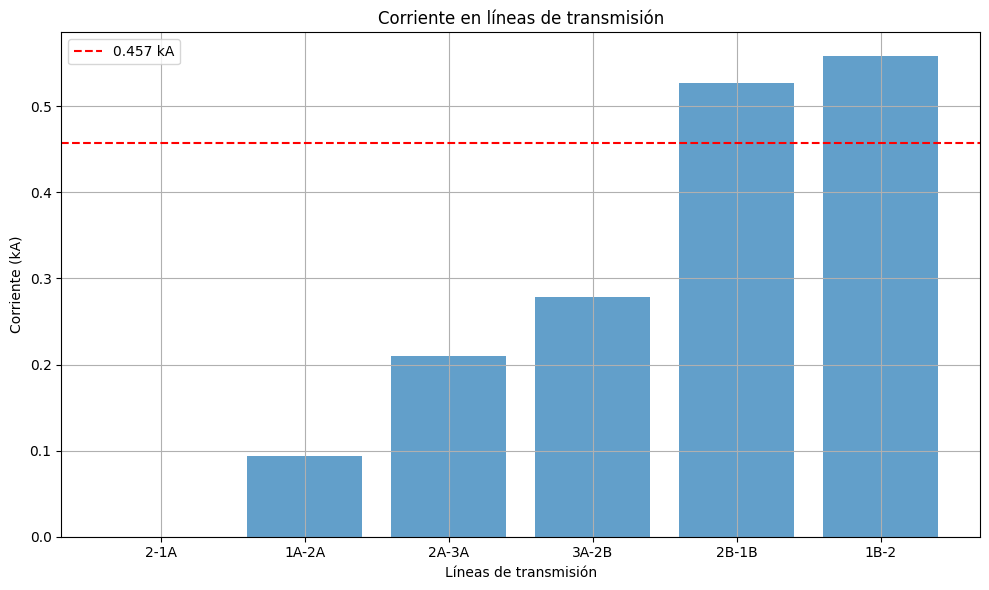

In [23]:
# Obtener las corrientes de las líneas específicas
line_currents = {
    '2-1A': net.res_line.at[0, 'i_ka'],    # Línea 2-1A
    '1A-2A': net.res_line.at[1, 'i_ka'],   # Línea 1A-2A
    '2A-3A': net.res_line.at[2, 'i_ka'],   # Línea 2A-3A
    '3A-2B': net.res_line.at[3, 'i_ka'],   # Línea 3A-2B
    '2B-1B': net.res_line.at[4, 'i_ka'],   # Línea 2B-1B
    '1B-2': net.res_line.at[5, 'i_ka']     # Línea 1B-2
}

import matplotlib.pyplot as plt

# Crear un gráfico de barras para las corrientes de las líneas específicas
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(line_currents)), line_currents.values(), align='center', alpha=0.7)

# Etiquetar las barras con los nombres de las líneas
plt.xticks(range(len(line_currents)), line_currents.keys())

# Agregar etiquetas y título al gráfico
plt.xlabel('Líneas de transmisión')
plt.ylabel('Corriente (kA)')
plt.title('Corriente en líneas de transmisión')

# Agregar una línea segmentada correspondiente a 0.457 kA
plt.axhline(y=0.457, color='r', linestyle='--', label='0.457 kA')

# Mostrar el gráfico
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



/Users/josegutierrez/Library/Python/3.9/lib/python/site-packages/pandapower/create.py:2369: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  net.trafo.tap_phase_shifter.fillna(False, inplace=True)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



      vm_pu  va_degree        p_mw     q_mvar
0  1.000000   0.000000 -197.055175 -32.797374
1  0.998909 -13.846520    0.000000   0.000000
2  0.998109 -13.886720   26.673565  17.299099
3  0.978201 -15.281519   47.365601  39.690895
4  0.981601 -15.151818   20.936843  14.212963
5  0.983935 -14.962597   85.094474  57.383307
6  0.995586 -14.165545   13.503127  10.305983


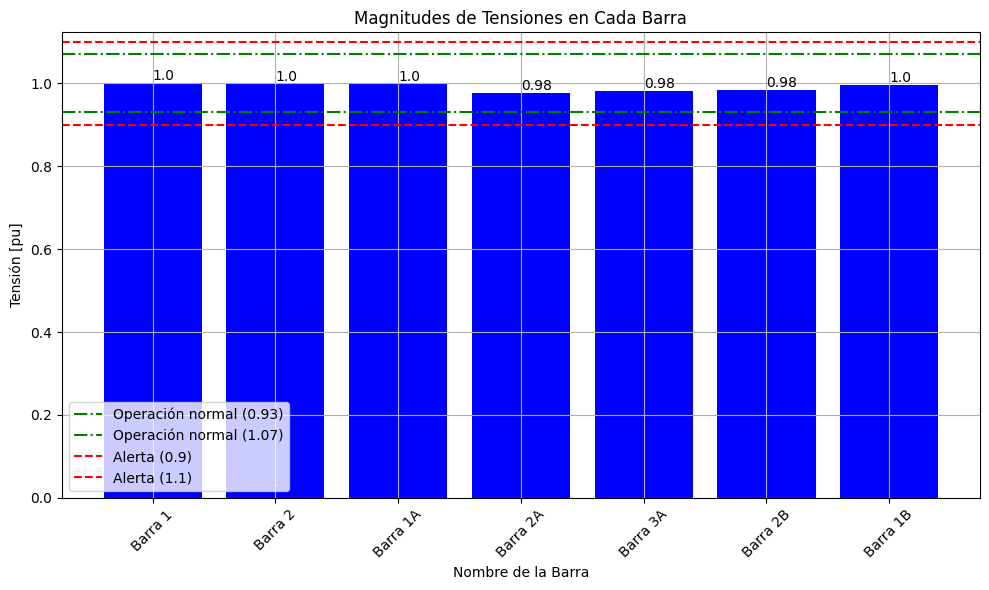

In [24]:
#Instancia 1 Desconexión de la línea 1A-2A
import numpy as np
import matplotlib.pyplot as plt
import pandapower as pp

# Definición de parámetros
Vg_LL = 110  # Voltaje de la línea en kV
Vg_LL2 = 220 # Voltaje de barras
P = 150  # Potencia activa en MW
Q = 100  # Potencia reactiva en Mvar

# Creación de la red eléctrica
net = pp.create_empty_network()

# Añadir barras
bus1 = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 1", slack=True)  # Barra 1 es slack
bus2 = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 2")  # Barra 2 se conecta a la carga
bus1A = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 1A")  # Barra 1A se conecta a la carga
bus2A = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 2A")  # Barra 2A se conecta a la carga
bus3A = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 3A")  # Barra 3A se conecta a la carga
bus2B = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 2B")  # Barra 2B se conecta a la carga
bus1B = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 1B")  # Barra 1B se conecta a la carga

# Añadir transformador entre barra 1 y barra 2
trafo1 = pp.create_transformer(net, hv_bus=bus2, lv_bus=bus1, name="trafo1", std_type="100 MVA 220/110 kV")

# Añadir líneas
pp.create_line(net, from_bus=bus2, to_bus=bus1A, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus1A, to_bus=bus2A, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=False)
pp.create_line(net, from_bus=bus2A, to_bus=bus3A, length_km=20, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus3A, to_bus=bus2B, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus2B, to_bus=bus1B, length_km=30, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus1B, to_bus=bus2, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)

# Añadir carga a las barras con variabilidad de ±15%
pp.create_load(net, bus=bus1A, p_mw=0.2 * P * (1 + np.random.uniform(-0.15, 0.15)), q_mvar=0.2 * Q * (1 + np.random.uniform(-0.15, 0.15)))
pp.create_load(net, bus=bus2A, p_mw=0.35 * P * (1 + np.random.uniform(-0.15, 0.15)), q_mvar=0.35 * Q * (1 + np.random.uniform(-0.15, 0.15)))
pp.create_load(net, bus=bus3A, p_mw=0.15 * P * (1 + np.random.uniform(-0.15, 0.15)), q_mvar=0.15 * Q * (1 + np.random.uniform(-0.15, 0.15)))
pp.create_load(net, bus=bus2B, p_mw=0.6 * P * (1 + np.random.uniform(-0.15, 0.15)), q_mvar=0.6 * Q * (1 + np.random.uniform(-0.15, 0.15)))
pp.create_load(net, bus=bus1B, p_mw=0.1 * P * (1 + np.random.uniform(-0.15, 0.15)), q_mvar=0.1 * Q * (1 + np.random.uniform(-0.15, 0.15)))


# Añadir generación a la barra 1
pp.create_ext_grid(net, bus=bus1, vm_pu=1, va_degree=0.0)

# Definir función para verificar si todas las barras están dentro del rango deseado
def todas_barras_dentro_rango(voltajes):
    for v in voltajes:
        if v < 0.93 or v > 1.07:
            return False
    return True

# Inicializar el tap del transformador para que las barras del sistema estén dentro del rango de operación normal (0.93-1.07 pu)
tap_inicial = 1.0
tap_actual = tap_inicial
net.trafo.tap_pos.at[trafo1] = tap_actual

# Simular el flujo de carga inicial
pp.runpp(net)

# Obtener resultados de las tensiones en las barras
voltajes = net.res_bus.vm_pu.values
nombres_barras = net.bus.name.values

# Iterar para ajustar el tap hasta que todas las barras estén dentro del rango
while not todas_barras_dentro_rango(voltajes):
    if any(v < 0.93 for v in voltajes):
        tap_actual += 0.005
    elif any(v > 1.07 for v in voltajes):
        tap_actual -= 0.005

    net.trafo.tap_pos.at[trafo1] = tap_actual
    pp.runpp(net)
    voltajes = net.res_bus.vm_pu.values

# Imprimir resultados de las barras
print(net.res_bus)

# Graficar barras de tensiones
plt.figure(figsize=(10, 6))
bars = plt.bar(nombres_barras, voltajes, color='blue')

# Añadir texto encima de las barras
for bar, valor in zip(bars, voltajes):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(valor, 2), va='bottom')

# Líneas segmentadas para el rango de operación normal (0.93 - 1.07) y alerta (0.9 - 1.1)
plt.axhline(y=0.93, color='green', linestyle='-.', label='Operación normal (0.93)')
plt.axhline(y=1.07, color='green', linestyle='-.', label='Operación normal (1.07)')
plt.axhline(y=0.9, color='red', linestyle='--', label='Alerta (0.9)')
plt.axhline(y=1.1, color='red', linestyle='--', label='Alerta (1.1)')

plt.title('Magnitudes de Tensiones en Cada Barra')
plt.xlabel('Nombre de la Barra')
plt.ylabel('Tensión [pu]')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


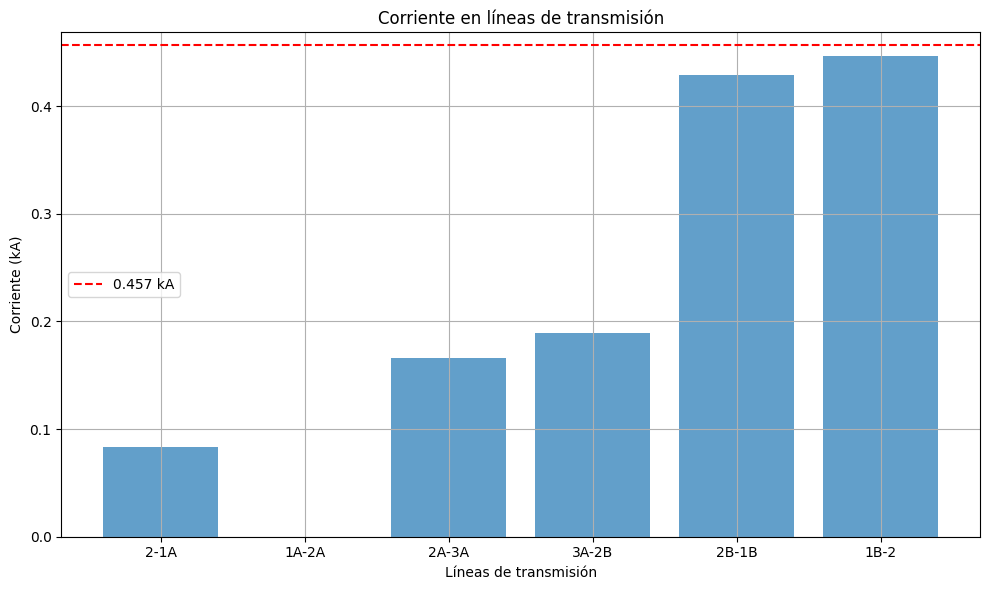

In [25]:
# Obtener las corrientes de las líneas específicas
line_currents = {
    '2-1A': net.res_line.at[0, 'i_ka'],    # Línea 2-1A
    '1A-2A': net.res_line.at[1, 'i_ka'],   # Línea 1A-2A
    '2A-3A': net.res_line.at[2, 'i_ka'],   # Línea 2A-3A
    '3A-2B': net.res_line.at[3, 'i_ka'],   # Línea 3A-2B
    '2B-1B': net.res_line.at[4, 'i_ka'],   # Línea 2B-1B
    '1B-2': net.res_line.at[5, 'i_ka']     # Línea 1B-2
}

import matplotlib.pyplot as plt

# Crear un gráfico de barras para las corrientes de las líneas específicas
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(line_currents)), line_currents.values(), align='center', alpha=0.7)

# Etiquetar las barras con los nombres de las líneas
plt.xticks(range(len(line_currents)), line_currents.keys())

# Agregar etiquetas y título al gráfico
plt.xlabel('Líneas de transmisión')
plt.ylabel('Corriente (kA)')
plt.title('Corriente en líneas de transmisión')

# Agregar una línea segmentada correspondiente a 0.457 kA
plt.axhline(y=0.457, color='r', linestyle='--', label='0.457 kA')

# Mostrar el gráfico
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/Users/josegutierrez/Library/Python/3.9/lib/python/site-packages/pandapower/create.py:2369: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  net.trafo.tap_phase_shifter.fillna(False, inplace=True)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



      vm_pu  va_degree        p_mw     q_mvar
0  1.000000   0.000000 -223.085825 -39.199976
1  0.998752 -15.719511    0.000000   0.000000
2  0.996681 -15.932653   32.763820  22.336303
3  0.994540 -16.159916   56.326591  30.298413
4  0.993845 -16.247153   21.479624  15.832820
5  0.987711 -16.344412   93.581418  56.957561
6  0.996405 -15.921722   16.230281   9.927223


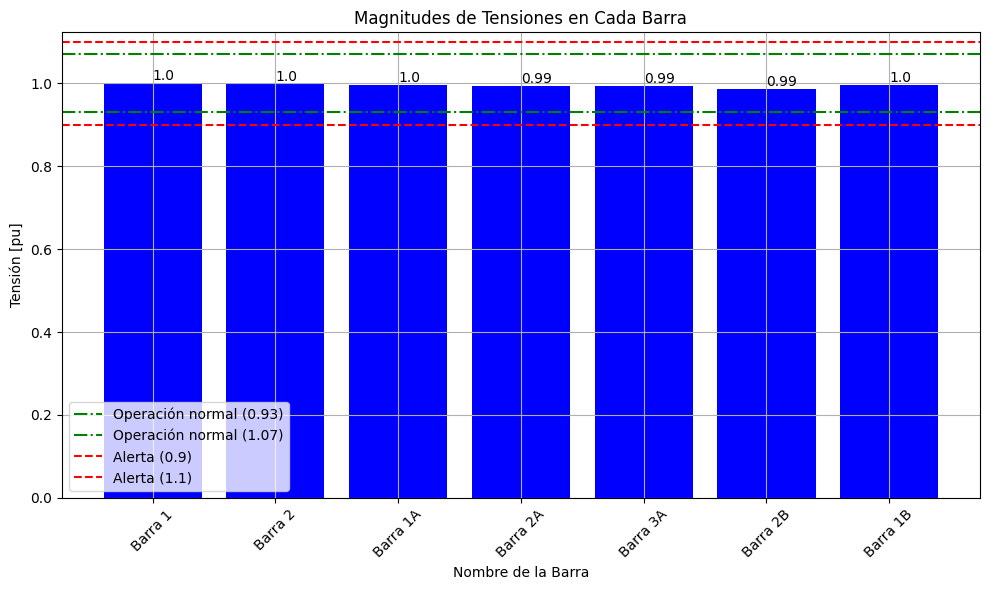

In [26]:
#Instancia 1 Desconexión de la línea 3A-2B
import numpy as np
import matplotlib.pyplot as plt
import pandapower as pp

# Definición de parámetros
Vg_LL = 110  # Voltaje de la línea en kV
Vg_LL2 = 220 # Voltaje de barras
P = 150  # Potencia activa en MW
Q = 100  # Potencia reactiva en Mvar

# Creación de la red eléctrica
net = pp.create_empty_network()

# Añadir barras
bus1 = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 1", slack=True)  # Barra 1 es slack
bus2 = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 2")  # Barra 2 se conecta a la carga
bus1A = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 1A")  # Barra 1A se conecta a la carga
bus2A = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 2A")  # Barra 2A se conecta a la carga
bus3A = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 3A")  # Barra 3A se conecta a la carga
bus2B = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 2B")  # Barra 2B se conecta a la carga
bus1B = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 1B")  # Barra 1B se conecta a la carga

# Añadir transformador entre barra 1 y barra 2
trafo1 = pp.create_transformer(net, hv_bus=bus2, lv_bus=bus1, name="trafo1", std_type="100 MVA 220/110 kV")

# Añadir líneas
pp.create_line(net, from_bus=bus2, to_bus=bus1A, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus1A, to_bus=bus2A, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus2A, to_bus=bus3A, length_km=20, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus3A, to_bus=bus2B, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=False)
pp.create_line(net, from_bus=bus2B, to_bus=bus1B, length_km=30, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus1B, to_bus=bus2, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)

# Añadir carga a las barras con variabilidad de ±15%
pp.create_load(net, bus=bus1A, p_mw=0.2 * P * (1 + np.random.uniform(-0.15, 0.15)), q_mvar=0.2 * Q * (1 + np.random.uniform(-0.15, 0.15)))
pp.create_load(net, bus=bus2A, p_mw=0.35 * P * (1 + np.random.uniform(-0.15, 0.15)), q_mvar=0.35 * Q * (1 + np.random.uniform(-0.15, 0.15)))
pp.create_load(net, bus=bus3A, p_mw=0.15 * P * (1 + np.random.uniform(-0.15, 0.15)), q_mvar=0.15 * Q * (1 + np.random.uniform(-0.15, 0.15)))
pp.create_load(net, bus=bus2B, p_mw=0.6 * P * (1 + np.random.uniform(-0.15, 0.15)), q_mvar=0.6 * Q * (1 + np.random.uniform(-0.15, 0.15)))
pp.create_load(net, bus=bus1B, p_mw=0.1 * P * (1 + np.random.uniform(-0.15, 0.15)), q_mvar=0.1 * Q * (1 + np.random.uniform(-0.15, 0.15)))


# Añadir generación a la barra 1
pp.create_ext_grid(net, bus=bus1, vm_pu=1, va_degree=0.0)

# Definir función para verificar si todas las barras están dentro del rango deseado
def todas_barras_dentro_rango(voltajes):
    for v in voltajes:
        if v < 0.93 or v > 1.07:
            return False
    return True

# Inicializar el tap del transformador para que las barras del sistema estén dentro del rango de operación normal (0.93-1.07 pu)
tap_inicial = 1.0
tap_actual = tap_inicial
net.trafo.tap_pos.at[trafo1] = tap_actual

# Simular el flujo de carga inicial
pp.runpp(net)

# Obtener resultados de las tensiones en las barras
voltajes = net.res_bus.vm_pu.values
nombres_barras = net.bus.name.values

# Iterar para ajustar el tap hasta que todas las barras estén dentro del rango
while not todas_barras_dentro_rango(voltajes):
    if any(v < 0.93 for v in voltajes):
        tap_actual += 0.005
    elif any(v > 1.07 for v in voltajes):
        tap_actual -= 0.005

    net.trafo.tap_pos.at[trafo1] = tap_actual
    pp.runpp(net)
    voltajes = net.res_bus.vm_pu.values

# Imprimir resultados de las barras
print(net.res_bus)

# Graficar barras de tensiones
plt.figure(figsize=(10, 6))
bars = plt.bar(nombres_barras, voltajes, color='blue')

# Añadir texto encima de las barras
for bar, valor in zip(bars, voltajes):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(valor, 2), va='bottom')

# Líneas segmentadas para el rango de operación normal (0.93 - 1.07) y alerta (0.9 - 1.1)
plt.axhline(y=0.93, color='green', linestyle='-.', label='Operación normal (0.93)')
plt.axhline(y=1.07, color='green', linestyle='-.', label='Operación normal (1.07)')
plt.axhline(y=0.9, color='red', linestyle='--', label='Alerta (0.9)')
plt.axhline(y=1.1, color='red', linestyle='--', label='Alerta (1.1)')

plt.title('Magnitudes de Tensiones en Cada Barra')
plt.xlabel('Nombre de la Barra')
plt.ylabel('Tensión [pu]')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


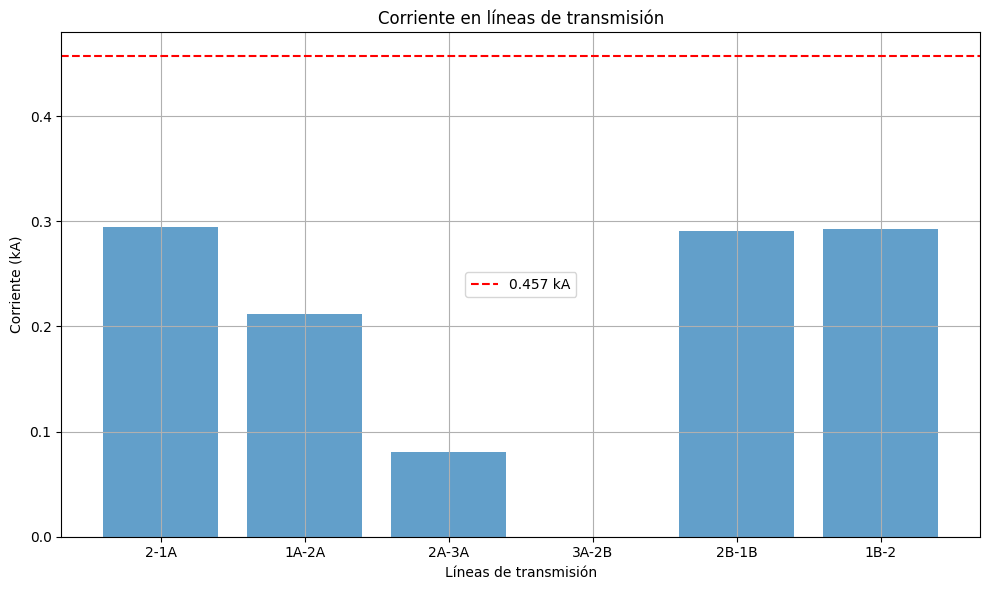

In [27]:
# Obtener las corrientes de las líneas específicas
line_currents = {
    '2-1A': net.res_line.at[0, 'i_ka'],    # Línea 2-1A
    '1A-2A': net.res_line.at[1, 'i_ka'],   # Línea 1A-2A
    '2A-3A': net.res_line.at[2, 'i_ka'],   # Línea 2A-3A
    '3A-2B': net.res_line.at[3, 'i_ka'],   # Línea 3A-2B
    '2B-1B': net.res_line.at[4, 'i_ka'],   # Línea 2B-1B
    '1B-2': net.res_line.at[5, 'i_ka']     # Línea 1B-2
}

import matplotlib.pyplot as plt

# Crear un gráfico de barras para las corrientes de las líneas específicas
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(line_currents)), line_currents.values(), align='center', alpha=0.7)

# Etiquetar las barras con los nombres de las líneas
plt.xticks(range(len(line_currents)), line_currents.keys())

# Agregar etiquetas y título al gráfico
plt.xlabel('Líneas de transmisión')
plt.ylabel('Corriente (kA)')
plt.title('Corriente en líneas de transmisión')

# Agregar una línea segmentada correspondiente a 0.457 kA
plt.axhline(y=0.457, color='r', linestyle='--', label='0.457 kA')

# Mostrar el gráfico
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/Users/josegutierrez/Library/Python/3.9/lib/python/site-packages/pandapower/create.py:2369: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  net.trafo.tap_phase_shifter.fillna(False, inplace=True)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

/var/folders/sc/qtzrdg213g5dztch4z33_q7w0000gn/T/ipykernel_1292/567315323.py:72: FutureWarning: Setting an item of 

      vm_pu  va_degree        p_mw     q_mvar
0  1.000000   0.000000 -214.135672 -89.053963
1  0.954903 -16.002370    0.000000   0.000000
2  0.949252 -16.354374   28.518398  21.787053
3  0.941772 -16.802120   57.954372  39.197534
4  0.935040 -17.190919   24.853755  13.548766
5  0.930024 -17.375632   84.944842  54.809321
6  0.954604 -16.029420   13.526698   8.935792


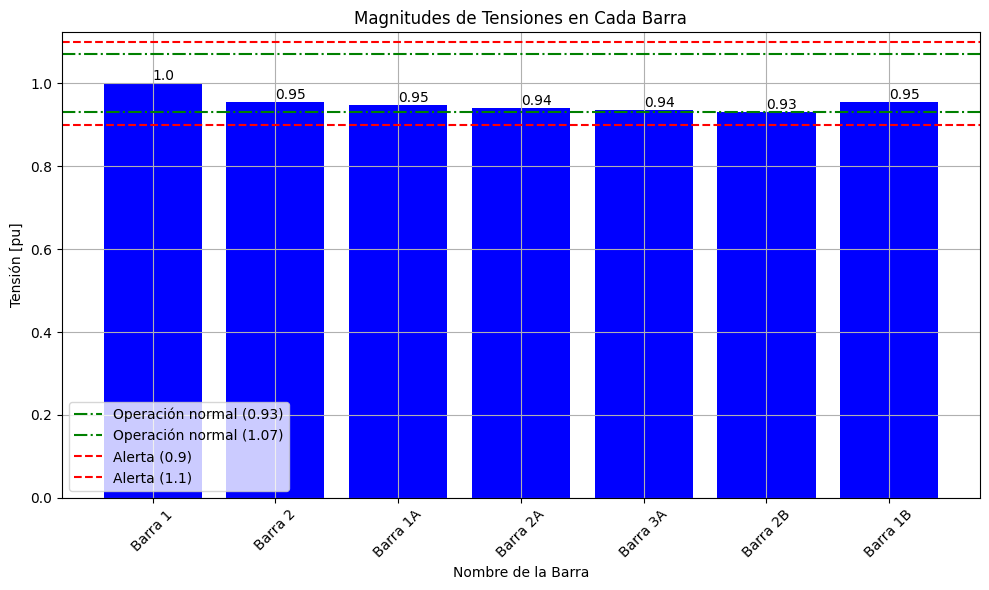

In [28]:
#Instancia 1 Desconexión de la línea 2B-1B
import numpy as np
import matplotlib.pyplot as plt
import pandapower as pp

# Definición de parámetros
Vg_LL = 110  # Voltaje de la línea en kV
Vg_LL2 = 220 # Voltaje de barras
P = 150  # Potencia activa en MW
Q = 100  # Potencia reactiva en Mvar

# Creación de la red eléctrica
net = pp.create_empty_network()

# Añadir barras
bus1 = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 1", slack=True)  # Barra 1 es slack
bus2 = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 2")  # Barra 2 se conecta a la carga
bus1A = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 1A")  # Barra 1A se conecta a la carga
bus2A = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 2A")  # Barra 2A se conecta a la carga
bus3A = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 3A")  # Barra 3A se conecta a la carga
bus2B = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 2B")  # Barra 2B se conecta a la carga
bus1B = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 1B")  # Barra 1B se conecta a la carga

# Añadir transformador entre barra 1 y barra 2
trafo1 = pp.create_transformer(net, hv_bus=bus2, lv_bus=bus1, name="trafo1", std_type="100 MVA 220/110 kV")

# Añadir líneas
pp.create_line(net, from_bus=bus2, to_bus=bus1A, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus1A, to_bus=bus2A, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus2A, to_bus=bus3A, length_km=20, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus3A, to_bus=bus2B, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus2B, to_bus=bus1B, length_km=30, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=False)
pp.create_line(net, from_bus=bus1B, to_bus=bus2, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)

# Añadir carga a las barras con variabilidad de ±15%
pp.create_load(net, bus=bus1A, p_mw=0.2 * P * (1 + np.random.uniform(-0.15, 0.15)), q_mvar=0.2 * Q * (1 + np.random.uniform(-0.15, 0.15)))
pp.create_load(net, bus=bus2A, p_mw=0.35 * P * (1 + np.random.uniform(-0.15, 0.15)), q_mvar=0.35 * Q * (1 + np.random.uniform(-0.15, 0.15)))
pp.create_load(net, bus=bus3A, p_mw=0.15 * P * (1 + np.random.uniform(-0.15, 0.15)), q_mvar=0.15 * Q * (1 + np.random.uniform(-0.15, 0.15)))
pp.create_load(net, bus=bus2B, p_mw=0.6 * P * (1 + np.random.uniform(-0.15, 0.15)), q_mvar=0.6 * Q * (1 + np.random.uniform(-0.15, 0.15)))
pp.create_load(net, bus=bus1B, p_mw=0.1 * P * (1 + np.random.uniform(-0.15, 0.15)), q_mvar=0.1 * Q * (1 + np.random.uniform(-0.15, 0.15)))


# Añadir generación a la barra 1
pp.create_ext_grid(net, bus=bus1, vm_pu=1, va_degree=0.0)

# Definir función para verificar si todas las barras están dentro del rango deseado
def todas_barras_dentro_rango(voltajes):
    for v in voltajes:
        if v < 0.93 or v > 1.07:
            return False
    return True

# Inicializar el tap del transformador para que las barras del sistema estén dentro del rango de operación normal (0.93-1.07 pu)
tap_inicial = 1.0
tap_actual = tap_inicial
net.trafo.tap_pos.at[trafo1] = tap_actual

# Simular el flujo de carga inicial
pp.runpp(net)

# Obtener resultados de las tensiones en las barras
voltajes = net.res_bus.vm_pu.values
nombres_barras = net.bus.name.values

# Iterar para ajustar el tap hasta que todas las barras estén dentro del rango
while not todas_barras_dentro_rango(voltajes):
    if any(v < 0.93 for v in voltajes):
        tap_actual += 0.005
    elif any(v > 1.07 for v in voltajes):
        tap_actual -= 0.005

    net.trafo.tap_pos.at[trafo1] = tap_actual
    pp.runpp(net)
    voltajes = net.res_bus.vm_pu.values

# Imprimir resultados de las barras
print(net.res_bus)

# Graficar barras de tensiones
plt.figure(figsize=(10, 6))
bars = plt.bar(nombres_barras, voltajes, color='blue')

# Añadir texto encima de las barras
for bar, valor in zip(bars, voltajes):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(valor, 2), va='bottom')

# Líneas segmentadas para el rango de operación normal (0.93 - 1.07) y alerta (0.9 - 1.1)
plt.axhline(y=0.93, color='green', linestyle='-.', label='Operación normal (0.93)')
plt.axhline(y=1.07, color='green', linestyle='-.', label='Operación normal (1.07)')
plt.axhline(y=0.9, color='red', linestyle='--', label='Alerta (0.9)')
plt.axhline(y=1.1, color='red', linestyle='--', label='Alerta (1.1)')

plt.title('Magnitudes de Tensiones en Cada Barra')
plt.xlabel('Nombre de la Barra')
plt.ylabel('Tensión [pu]')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


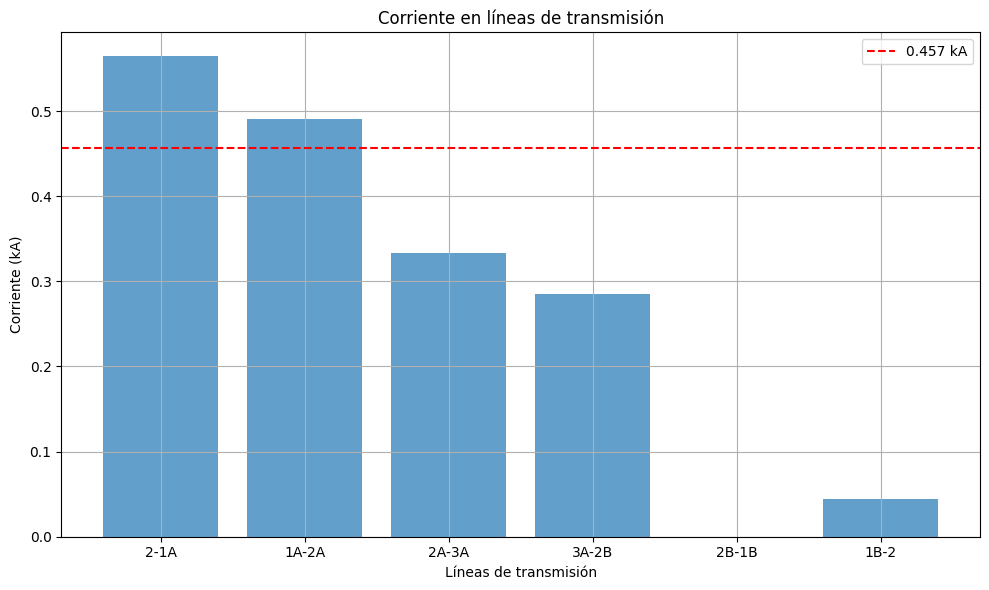

In [29]:
# Obtener las corrientes de las líneas específicas
line_currents = {
    '2-1A': net.res_line.at[0, 'i_ka'],    # Línea 2-1A
    '1A-2A': net.res_line.at[1, 'i_ka'],   # Línea 1A-2A
    '2A-3A': net.res_line.at[2, 'i_ka'],   # Línea 2A-3A
    '3A-2B': net.res_line.at[3, 'i_ka'],   # Línea 3A-2B
    '2B-1B': net.res_line.at[4, 'i_ka'],   # Línea 2B-1B
    '1B-2': net.res_line.at[5, 'i_ka']     # Línea 1B-2
}

import matplotlib.pyplot as plt

# Crear un gráfico de barras para las corrientes de las líneas específicas
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(line_currents)), line_currents.values(), align='center', alpha=0.7)

# Etiquetar las barras con los nombres de las líneas
plt.xticks(range(len(line_currents)), line_currents.keys())

# Agregar etiquetas y título al gráfico
plt.xlabel('Líneas de transmisión')
plt.ylabel('Corriente (kA)')
plt.title('Corriente en líneas de transmisión')

# Agregar una línea segmentada correspondiente a 0.457 kA
plt.axhline(y=0.457, color='r', linestyle='--', label='0.457 kA')

# Mostrar el gráfico
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/Users/josegutierrez/Library/Python/3.9/lib/python/site-packages/pandapower/create.py:2369: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  net.trafo.tap_phase_shifter.fillna(False, inplace=True)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



      vm_pu  va_degree        p_mw     q_mvar
0  1.000000   0.000000 -218.582822 -60.238798
1  0.972569 -15.784107    0.000000   0.000000
2  0.967777 -16.200858   30.555352  22.335286
3  0.961643 -16.742299   50.814994  34.611952
4  0.955983 -17.278793   24.198218  16.478133
5  0.951856 -17.584740   95.055546  67.487415
6  0.952681 -17.729447   13.196718   9.347679


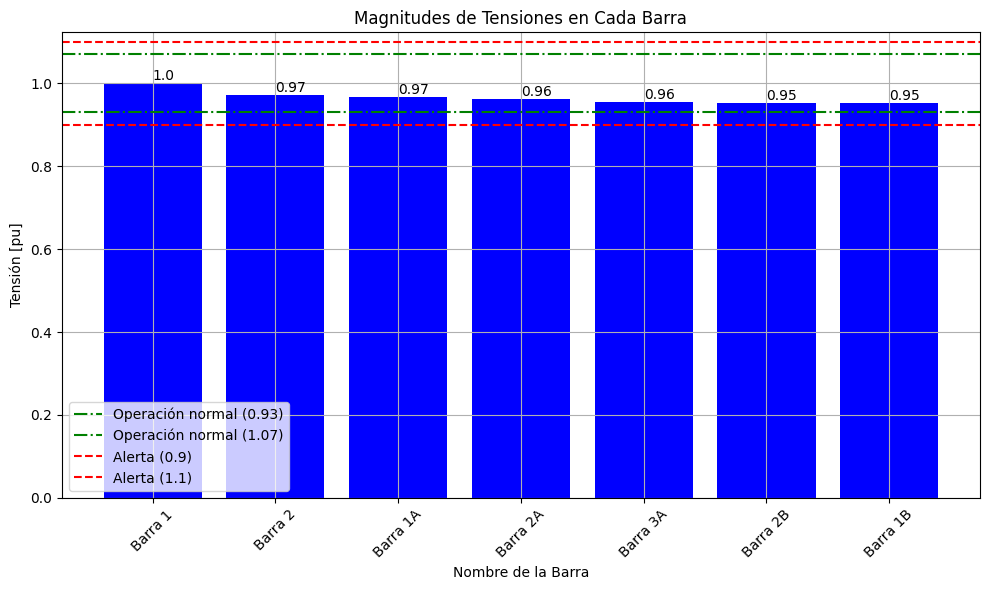

In [30]:
#Instancia 1 Desconexión de la línea 1B-2
import numpy as np
import matplotlib.pyplot as plt
import pandapower as pp

# Definición de parámetros
Vg_LL = 110  # Voltaje de la línea en kV
Vg_LL2 = 220 # Voltaje de barras
P = 150  # Potencia activa en MW
Q = 100  # Potencia reactiva en Mvar

# Creación de la red eléctrica
net = pp.create_empty_network()

# Añadir barras
bus1 = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 1", slack=True)  # Barra 1 es slack
bus2 = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 2")  # Barra 2 se conecta a la carga
bus1A = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 1A")  # Barra 1A se conecta a la carga
bus2A = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 2A")  # Barra 2A se conecta a la carga
bus3A = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 3A")  # Barra 3A se conecta a la carga
bus2B = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 2B")  # Barra 2B se conecta a la carga
bus1B = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 1B")  # Barra 1B se conecta a la carga

# Añadir transformador entre barra 1 y barra 2
trafo1 = pp.create_transformer(net, hv_bus=bus2, lv_bus=bus1, name="trafo1", std_type="100 MVA 220/110 kV")

# Añadir líneas
pp.create_line(net, from_bus=bus2, to_bus=bus1A, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus1A, to_bus=bus2A, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus2A, to_bus=bus3A, length_km=20, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus3A, to_bus=bus2B, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus2B, to_bus=bus1B, length_km=30, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus1B, to_bus=bus2, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=False)

# Añadir carga a las barras con variabilidad de ±15%
pp.create_load(net, bus=bus1A, p_mw=0.2 * P * (1 + np.random.uniform(-0.15, 0.15)), q_mvar=0.2 * Q * (1 + np.random.uniform(-0.15, 0.15)))
pp.create_load(net, bus=bus2A, p_mw=0.35 * P * (1 + np.random.uniform(-0.15, 0.15)), q_mvar=0.35 * Q * (1 + np.random.uniform(-0.15, 0.15)))
pp.create_load(net, bus=bus3A, p_mw=0.15 * P * (1 + np.random.uniform(-0.15, 0.15)), q_mvar=0.15 * Q * (1 + np.random.uniform(-0.15, 0.15)))
pp.create_load(net, bus=bus2B, p_mw=0.6 * P * (1 + np.random.uniform(-0.15, 0.15)), q_mvar=0.6 * Q * (1 + np.random.uniform(-0.15, 0.15)))
pp.create_load(net, bus=bus1B, p_mw=0.1 * P * (1 + np.random.uniform(-0.15, 0.15)), q_mvar=0.1 * Q * (1 + np.random.uniform(-0.15, 0.15)))


# Añadir generación a la barra 1
pp.create_ext_grid(net, bus=bus1, vm_pu=1, va_degree=0.0)

# Definir función para verificar si todas las barras están dentro del rango deseado
def todas_barras_dentro_rango(voltajes):
    for v in voltajes:
        if v < 0.93 or v > 1.07:
            return False
    return True

# Inicializar el tap del transformador para que las barras del sistema estén dentro del rango de operación normal (0.93-1.07 pu)
tap_inicial = 1.0
tap_actual = tap_inicial
net.trafo.tap_pos.at[trafo1] = tap_actual

# Simular el flujo de carga inicial
pp.runpp(net)

# Obtener resultados de las tensiones en las barras
voltajes = net.res_bus.vm_pu.values
nombres_barras = net.bus.name.values

# Iterar para ajustar el tap hasta que todas las barras estén dentro del rango
while not todas_barras_dentro_rango(voltajes):
    if any(v < 0.93 for v in voltajes):
        tap_actual += 0.005
    elif any(v > 1.07 for v in voltajes):
        tap_actual -= 0.005

    net.trafo.tap_pos.at[trafo1] = tap_actual
    pp.runpp(net)
    voltajes = net.res_bus.vm_pu.values

# Imprimir resultados de las barras
print(net.res_bus)

# Graficar barras de tensiones
plt.figure(figsize=(10, 6))
bars = plt.bar(nombres_barras, voltajes, color='blue')

# Añadir texto encima de las barras
for bar, valor in zip(bars, voltajes):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(valor, 2), va='bottom')

# Líneas segmentadas para el rango de operación normal (0.93 - 1.07) y alerta (0.9 - 1.1)
plt.axhline(y=0.93, color='green', linestyle='-.', label='Operación normal (0.93)')
plt.axhline(y=1.07, color='green', linestyle='-.', label='Operación normal (1.07)')
plt.axhline(y=0.9, color='red', linestyle='--', label='Alerta (0.9)')
plt.axhline(y=1.1, color='red', linestyle='--', label='Alerta (1.1)')

plt.title('Magnitudes de Tensiones en Cada Barra')
plt.xlabel('Nombre de la Barra')
plt.ylabel('Tensión [pu]')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


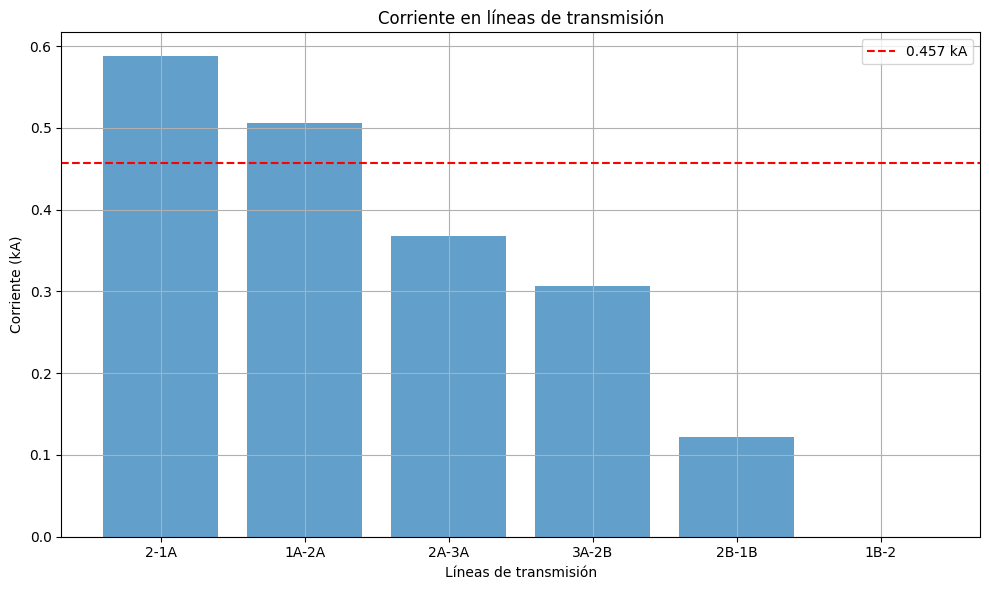

In [31]:
# Obtener las corrientes de las líneas específicas
line_currents = {
    '2-1A': net.res_line.at[0, 'i_ka'],    # Línea 2-1A
    '1A-2A': net.res_line.at[1, 'i_ka'],   # Línea 1A-2A
    '2A-3A': net.res_line.at[2, 'i_ka'],   # Línea 2A-3A
    '3A-2B': net.res_line.at[3, 'i_ka'],   # Línea 3A-2B
    '2B-1B': net.res_line.at[4, 'i_ka'],   # Línea 2B-1B
    '1B-2': net.res_line.at[5, 'i_ka']     # Línea 1B-2
}

import matplotlib.pyplot as plt

# Crear un gráfico de barras para las corrientes de las líneas específicas
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(line_currents)), line_currents.values(), align='center', alpha=0.7)

# Etiquetar las barras con los nombres de las líneas
plt.xticks(range(len(line_currents)), line_currents.keys())

# Agregar etiquetas y título al gráfico
plt.xlabel('Líneas de transmisión')
plt.ylabel('Corriente (kA)')
plt.title('Corriente en líneas de transmisión')

# Agregar una línea segmentada correspondiente a 0.457 kA
plt.axhline(y=0.457, color='r', linestyle='--', label='0.457 kA')

# Mostrar el gráfico
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()